## **Association Rule Mining Comparison : Apriori vs Brute Force**

**Author** : Gerry Julian (G2507395K) <br> **Project** : IN6227 Data Mining - Assignment 2 <br> 

## **1. Import Libraries**

In [59]:

import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations
from mlxtend.frequent_patterns import apriori, association_rules
from IPython.display import display
import os
import numpy as np
import seaborn as sns
import ast
import time

### **2.Load Dataset & Create Backup**

2.1 Load Dataset

In [60]:

#Data Source
data_path = "../data_source/market_basket.csv"

#Set Column Name
columns = [
    "BillNo", "Itemname","Quantity","Date", "Price","CustomerID", "Country"
]

# ✅ Check if dataset file exists before reading
if os.path.exists(data_path):
    print("File found!")
else:
    raise FileNotFoundError(f"File not found at: {data_path}")

# Read CSV file
data = pd.read_csv(data_path, names=columns, sep=";", low_memory=False)

# Show dataset info
print("Dataset Info:")
data.info()
print("\nSample Data:")
display(data.head())



File found!
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522065 entries, 0 to 522064
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   BillNo      522065 non-null  object
 1   Itemname    520610 non-null  object
 2   Quantity    522065 non-null  object
 3   Date        522065 non-null  object
 4   Price       522065 non-null  object
 5   CustomerID  388024 non-null  object
 6   Country     522065 non-null  object
dtypes: object(7)
memory usage: 27.9+ MB

Sample Data:


,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
1,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850,United Kingdom
2,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850,United Kingdom
3,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850,United Kingdom
4,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850,United Kingdom


2.2 Create Backup

In [61]:
backup_path = "../data_source/market_basket_backup.csv"

# Check if backup already exists
if os.path.exists(backup_path):
    print(f"Backup already exists at: {backup_path}")
else:
    # Save backup only if not existing
    data.to_csv(backup_path, index=False)
    print(f"Backup saved successfully at: {backup_path}")

Backup already exists at: ../data_source/market_basket_backup.csv


### **3.Initial Study and Cleaning Dataset**

**3.1 Check and Drop Duplicated Data**

In [62]:
print("\n--- Check Duplicate Rows ---")
print(f"Current dataset shape: {data.shape}")
print(f"Number of duplicate rows: {data.duplicated().sum()}")

# Drop duplicates and reset index
data = data.drop_duplicates().reset_index(drop=True)
print(f"\nDuplicate rows removed (if any). Updated dataset shape: {data.shape}")
print(f"Number of duplicate rows after cleaning: {data.duplicated().sum()}")



--- Check Duplicate Rows ---
Current dataset shape: (522065, 7)
Number of duplicate rows: 5286

Duplicate rows removed (if any). Updated dataset shape: (516779, 7)
Number of duplicate rows after cleaning: 0


**3.2 Check and Handle Missing Values**

In [63]:
print("\n--- Check Missing Values Before Dropping ---")
print(data.isnull().sum())

# Drop rows where 'Itemname' is missing
data = data.dropna(subset=['Itemname']).reset_index(drop=True)

print("\nMissing values in 'Itemname' removed (if any). Updated dataset shape:")
print(data.shape)
print("Missing values after cleaning:")
print(data.isnull().sum())


--- Check Missing Values Before Dropping ---
BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    133967
Country            0
dtype: int64

Missing values in 'Itemname' removed (if any). Updated dataset shape:
(515324, 7)
Missing values after cleaning:
BillNo             0
Itemname           0
Quantity           0
Date               0
Price              0
CustomerID    132512
Country            0
dtype: int64


**3.3 Text Normalization**

In [64]:
data['Itemname'] = data['Itemname'].astype(str).str.strip().str.lower()
data['Itemname'] = data['Itemname'].str.replace(r'[^a-z0-9\s]', '', regex=True)
data = data[data['Itemname'] != '']

# Keep only relevant columns for MBA
data = data[['BillNo', 'Itemname']].copy()

# Check results
print("\n--- Sample of Cleaned Itemnames ---")
print(data['Itemname'].head(20))
print(f"\nTotal records after text normalization: {len(data)}")



--- Sample of Cleaned Itemnames ---
0                                itemname
1       white hanging heart tlight holder
2                     white metal lantern
3          cream cupid hearts coat hanger
4     knitted union flag hot water bottle
5           red woolly hottie white heart
6            set 7 babushka nesting boxes
7        glass star frosted tlight holder
8                  hand warmer union jack
9               hand warmer red polka dot
10          assorted colour bird ornament
11               poppys playhouse bedroom
12               poppys playhouse kitchen
13      feltcraft princess charlotte doll
14                 ivory knitted mug cosy
15     box of 6 assorted colour teaspoons
16           box of vintage jigsaw blocks
17         box of vintage alphabet blocks
18               home building block word
19               love building block word
Name: Itemname, dtype: object

Total records after text normalization: 515269


### **4.Data Exploration**

/var/folders/kg/_sft4vyd1gg4spmzmmcc7jzm0000gn/T/ipykernel_26025/1282521972.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


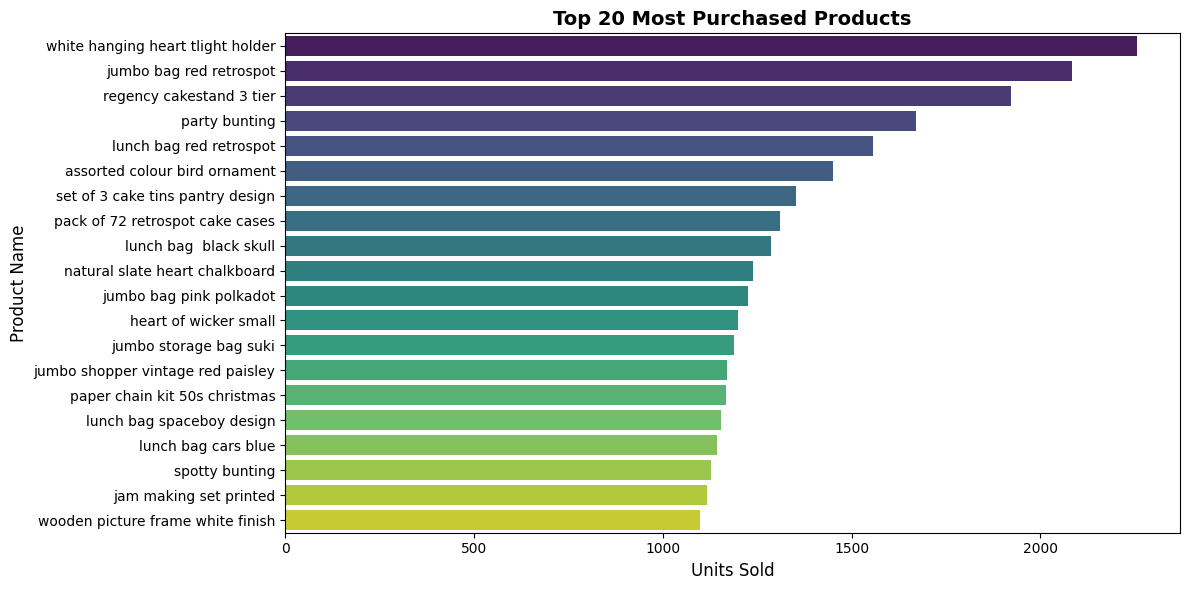


--- Item Frequency Summary ---
count    4140.000000
mean      124.461111
std       187.017021
min         1.000000
25%        12.000000
50%        58.000000
75%       156.250000
max      2257.000000
Name: count, dtype: float64


In [65]:
# Count item frequencies
product_counts = data['Itemname'].value_counts()

# Get top 20 most purchased items
top_products = product_counts.head(20)

# Plot the top 20
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")

# Title and labels
plt.title("Top 20 Most Purchased Products", fontsize=14, fontweight='bold')
plt.xlabel("Units Sold", fontsize=12)
plt.ylabel("Product Name", fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()

# Optional: Show summary stats
print("\n--- Item Frequency Summary ---")
print(product_counts.describe())



### **5.Data Preprocessing**

In [66]:
DATA_SOURCE_DIR = "../data_source"
DATA_FILE_NAME = "market_basket.csv"
DATA_PATH = os.path.join(DATA_SOURCE_DIR, DATA_FILE_NAME)

print("\n---  Generating Transaction-Based Sample Subsets ---")

os.makedirs(DATA_SOURCE_DIR, exist_ok=True)

# Identify the unique BillNos (the transactions)
all_billnos = data['BillNo'].unique()
total_transactions = len(all_billnos) 

sample_sizes = [5000, 10000, 15000, 20000]

for size in sample_sizes:
    if size <= total_transactions:
        
        # Sample the BillNos (Transactions)
        np.random.seed(42)
        sampled_billnos = np.random.choice(all_billnos, size=size, replace=False)
        
        # Filter the original 'data' to include ALL rows for the sampled BillNos.
        subset = data[data['BillNo'].isin(sampled_billnos)].reset_index(drop=True)
        
        # Save the complete, valid transactions to a CSV file in /data_source
        file_path = os.path.join(DATA_SOURCE_DIR, f"market_basket_{size}.csv")
        subset.to_csv(file_path, index=False)
        print(f" Subset of {size} COMPLETE transactions saved. (Total item rows: {len(subset)})")
    else:
        print(f"Skipping {size} — dataset only has {total_transactions} unique transactions.")



---  Generating Transaction-Based Sample Subsets ---
 Subset of 5000 COMPLETE transactions saved. (Total item rows: 128168)
 Subset of 10000 COMPLETE transactions saved. (Total item rows: 251586)
 Subset of 15000 COMPLETE transactions saved. (Total item rows: 380951)
 Subset of 20000 COMPLETE transactions saved. (Total item rows: 512376)


**6.Apply Apriori and Generate Association Ruless**

In [67]:
# --- Configuration Parameter ---

RESULTS_DIR = "../results"
sample_sizes = [5000, 10000, 15000, 20000]
N_TOP_ITEMS = 250
MIN_SUPPORT = 0.01
MIN_CONFIDENCE = 0.5
METRIC = "confidence"
MIN_THRESHOLD = MIN_CONFIDENCE
comparison_results = []

# Brute-Force Function (Defined locally for the loop)
def brute_force_rules_size_2(df_ohe, min_support, min_confidence):
    transactions = len(df_ohe)
    items = df_ohe.columns
    rules_list = []
    columns_to_use = ['antecedents', 'consequents', 'support', 'confidence', 'lift']

    for A, B in combinations(items, 2):
        support_AB = df_ohe[[A, B]].all(axis=1).sum() / transactions
        
        if support_AB >= min_support:
            support_A = df_ohe[A].sum() / transactions
            support_B = df_ohe[B].sum() / transactions

            # Rule 1: A -> B
            confidence_AB = support_AB / support_A
            lift_AB = confidence_AB / support_B
            if confidence_AB >= min_confidence:
                rules_list.append({'antecedents': frozenset({A}), 'consequents': frozenset({B}), 
                                   'support': support_AB, 'confidence': confidence_AB, 'lift': lift_AB})

            # Rule 2: B -> A
            confidence_BA = support_AB / support_B
            lift_BA = confidence_BA / support_A
            if confidence_BA >= min_confidence:
                rules_list.append({'antecedents': frozenset({B}), 'consequents': frozenset({A}), 
                                   'support': support_AB, 'confidence': confidence_BA, 'lift': lift_BA})

    return pd.DataFrame(rules_list, columns=columns_to_use)


# One Hot Encoding and Combine Apriori with Brute Force for Comparison Analysis

print("\n" + "="*80)
print("2. OHE and Iterative Analysis Across Sample Sizes (Apriori vs. Brute-Force)")
print("="*80)
print(f"Global Parameters: Min Support={MIN_SUPPORT}, Min Confidence={MIN_CONFIDENCE}, Top Items Filter={N_TOP_ITEMS}")

final_rules_apriori = pd.DataFrame() # Store the last run's Apriori rules for recommendation

for SAMPLE_SIZE in sample_sizes:
    print(f"\n--- Analyzing Sample Size: {SAMPLE_SIZE} Transactions ---")
    
    ANALYSIS_FILE = os.path.join(DATA_SOURCE_DIR, f"market_basket_{SAMPLE_SIZE}.csv")
    analysis_data = pd.read_csv(ANALYSIS_FILE)

    # 2.1 Item Filtering (Top N)
    item_counts = analysis_data['Itemname'].value_counts()
    top_items = item_counts.head(N_TOP_ITEMS).index
    analysis_data = analysis_data[analysis_data['Itemname'].isin(top_items)]
    
    # 2.2 Grouping and OHE (One-Hot Encoding)
    grouped_data = analysis_data.groupby('BillNo')['Itemname'].apply(list).reset_index()
    transactions = [t for t in grouped_data['Itemname'].tolist() if t]
    
    te = TransactionEncoder()
    oht = te.fit(transactions).transform(transactions)
    df_ohe = pd.DataFrame(oht, columns=te.columns_)

    current_unique_items = df_ohe.shape[1]
    
    if current_unique_items == 0:
        print("Skipping: Zero unique items remaining after filtering.")
        continue

    print(f"Total transactions analyzed: {len(df_ohe)} | Unique items: {current_unique_items}")
    
    # Apriori Algorithm 
    start_time_apriori = time.time()
    frequent_itemsets_apriori = apriori(df_ohe, min_support=MIN_SUPPORT, use_colnames=True)
    rules_apriori = association_rules(frequent_itemsets_apriori, metric=METRIC, min_threshold=MIN_THRESHOLD)
    time_apriori_total = time.time() - start_time_apriori
    
    rules_apriori = rules_apriori.sort_values(by=['lift', 'confidence'], ascending=False).reset_index(drop=True)
    final_rules_apriori = rules_apriori # Store the last one for step 5
    
    print(f"Apriori Time: {time_apriori_total:.4f}s | Rules Found: {len(rules_apriori)}")
    print("Top 3 Apriori Rules:")
    if not rules_apriori.empty:
        display(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(3))
    else:
        print("No Apriori rules found for this sample size.")


    

    # Brute-Force Approach 
    start_time_brute = time.time()
    rules_brute_force = brute_force_rules_size_2(df_ohe, MIN_SUPPORT, MIN_CONFIDENCE)
    time_brute_total = time.time() - start_time_brute

    print(f"Brute-Force Time: {time_brute_total:.4f}s | Rules Found: {len(rules_brute_force)}")
    print("Top 3 Brute-Force Rules:")
    if not rules_brute_force.empty:
        rules_brute_force = rules_brute_force.sort_values(by=['lift', 'confidence'], ascending=False).reset_index(drop=True)
        display(rules_brute_force[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(3))
    else:
        print("No Brute-Force rules found for this sample size.")

    # Store results
    comparison_results.append({
        'Sample Size': SAMPLE_SIZE,
        'Unique Items': current_unique_items,
        'Apriori Time': time_apriori_total,
        'Apriori Rules': len(rules_apriori),
        'Brute-Force Time': time_brute_total,
        'Brute-Force Rules': len(rules_brute_force)
    })

# Save results and the final Apriori rules for the next script
comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv(os.path.join(RESULTS_DIR, "comparison_results.csv"), index=False)
if not final_rules_apriori.empty:
    final_rules_apriori.to_csv(os.path.join(RESULTS_DIR, "final_rules_apriori.csv"), index=False)





2. OHE and Iterative Analysis Across Sample Sizes (Apriori vs. Brute-Force)
Global Parameters: Min Support=0.01, Min Confidence=0.5, Top Items Filter=250

--- Analyzing Sample Size: 5000 Transactions ---
Total transactions analyzed: 4304 | Unique items: 250
Apriori Time: 1.4415s | Rules Found: 1418
Top 3 Apriori Rules:


,antecedents,consequents,support,confidence,lift
0,"(white spot blue ceramic drawer knob, blue str...",(blue spot ceramic drawer knob),0.010455,0.762712,30.116623
1,"(wooden heart christmas scandinavian, wooden t...",(wooden star christmas scandinavian),0.016961,0.960526,28.315789
2,(wooden star christmas scandinavian),"(wooden heart christmas scandinavian, wooden t...",0.016961,0.500000,28.315789


Brute-Force Time: 5.1103s | Rules Found: 148
Top 3 Brute-Force Rules:


,antecedents,consequents,support,confidence,lift
0,(wooden tree christmas scandinavian),(wooden star christmas scandinavian),0.020446,0.854369,25.186328
1,(wooden star christmas scandinavian),(wooden tree christmas scandinavian),0.020446,0.602740,25.186328
2,(small marshmallows pink bowl),(small dolly mix design orange bowl),0.021840,0.740157,24.133620



--- Analyzing Sample Size: 10000 Transactions ---
Total transactions analyzed: 8641 | Unique items: 250
Apriori Time: 2.6450s | Rules Found: 1119
Top 3 Apriori Rules:


,antecedents,consequents,support,confidence,lift
0,"(red retrospot charlotte bag, strawberry charl...","(woodland charlotte bag, charlotte bag pink po...",0.011688,0.631250,29.806728
1,"(woodland charlotte bag, charlotte bag pink po...","(red retrospot charlotte bag, strawberry charl...",0.011688,0.551913,29.806728
2,"(red retrospot charlotte bag, woodland charlot...","(strawberry charlotte bag, charlotte bag pink ...",0.011688,0.639241,29.225805


Brute-Force Time: 5.9578s | Rules Found: 126
Top 3 Brute-Force Rules:


,antecedents,consequents,support,confidence,lift
0,(small dolly mix design orange bowl),(small marshmallows pink bowl),0.019211,0.664000,26.811327
1,(small marshmallows pink bowl),(small dolly mix design orange bowl),0.019211,0.775701,26.811327
2,(set6 red spotty paper cups),(set6 red spotty paper plates),0.019558,0.808612,26.267745



--- Analyzing Sample Size: 15000 Transactions ---
Total transactions analyzed: 12935 | Unique items: 250


/var/folders/kg/_sft4vyd1gg4spmzmmcc7jzm0000gn/T/ipykernel_26025/2079436202.py:56: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_data = pd.read_csv(ANALYSIS_FILE)


Apriori Time: 4.4092s | Rules Found: 1260
Top 3 Apriori Rules:


,antecedents,consequents,support,confidence,lift
0,"(set20 red retrospot paper napkins, set6 red s...",(set6 red spotty paper cups),0.015385,0.723636,29.342434
1,(set6 red spotty paper cups),"(set20 red retrospot paper napkins, set6 red s...",0.015385,0.623824,29.342434
2,"(set20 red retrospot paper napkins, set6 red s...",(set6 red spotty paper plates),0.015385,0.904545,29.324049


Brute-Force Time: 6.7354s | Rules Found: 134
Top 3 Brute-Force Rules:


,antecedents,consequents,support,confidence,lift
0,(set6 red spotty paper cups),(set6 red spotty paper plates),0.020410,0.827586,26.829142
1,(set6 red spotty paper plates),(set6 red spotty paper cups),0.020410,0.661654,26.829142
2,(small marshmallows pink bowl),(small dolly mix design orange bowl),0.020332,0.794562,25.953683



--- Analyzing Sample Size: 20000 Transactions ---
Total transactions analyzed: 17276 | Unique items: 250
Apriori Time: 5.9359s | Rules Found: 1261
Top 3 Apriori Rules:


,antecedents,consequents,support,confidence,lift
0,"(strawberry charlotte bag, charlotte bag pink ...","(red retrospot charlotte bag, woodland charlot...",0.011693,0.538667,27.945962
1,"(red retrospot charlotte bag, woodland charlot...","(strawberry charlotte bag, charlotte bag pink ...",0.011693,0.606607,27.945962
2,"(red retrospot charlotte bag, strawberry charl...","(woodland charlotte bag, charlotte bag pink po...",0.011693,0.613982,27.197818


Brute-Force Time: 7.4833s | Rules Found: 124
Top 3 Brute-Force Rules:


,antecedents,consequents,support,confidence,lift
0,(small marshmallows pink bowl),(small dolly mix design orange bowl),0.01997,0.778781,25.873502
1,(small dolly mix design orange bowl),(small marshmallows pink bowl),0.01997,0.663462,25.873502
2,(wooden star christmas scandinavian),(wooden heart christmas scandinavian),0.02188,0.763636,25.370350


**7.Compare Two Models**


3. Scalability Comparison: Time and Rule Count
## Performance Comparison Table
             Unique Items  Apriori Time  Apriori Rules  Brute-Force Time  Brute-Force Rules
Sample Size                                                                                
5000                  250      1.441522           1418          5.110289                148
10000                 250      2.645028           1119          5.957796                126
15000                 250      4.409247           1260          6.735406                134
20000                 250      5.935949           1261          7.483344                124
Scalability comparison plot saved to: ../results/scalability_comparison.png


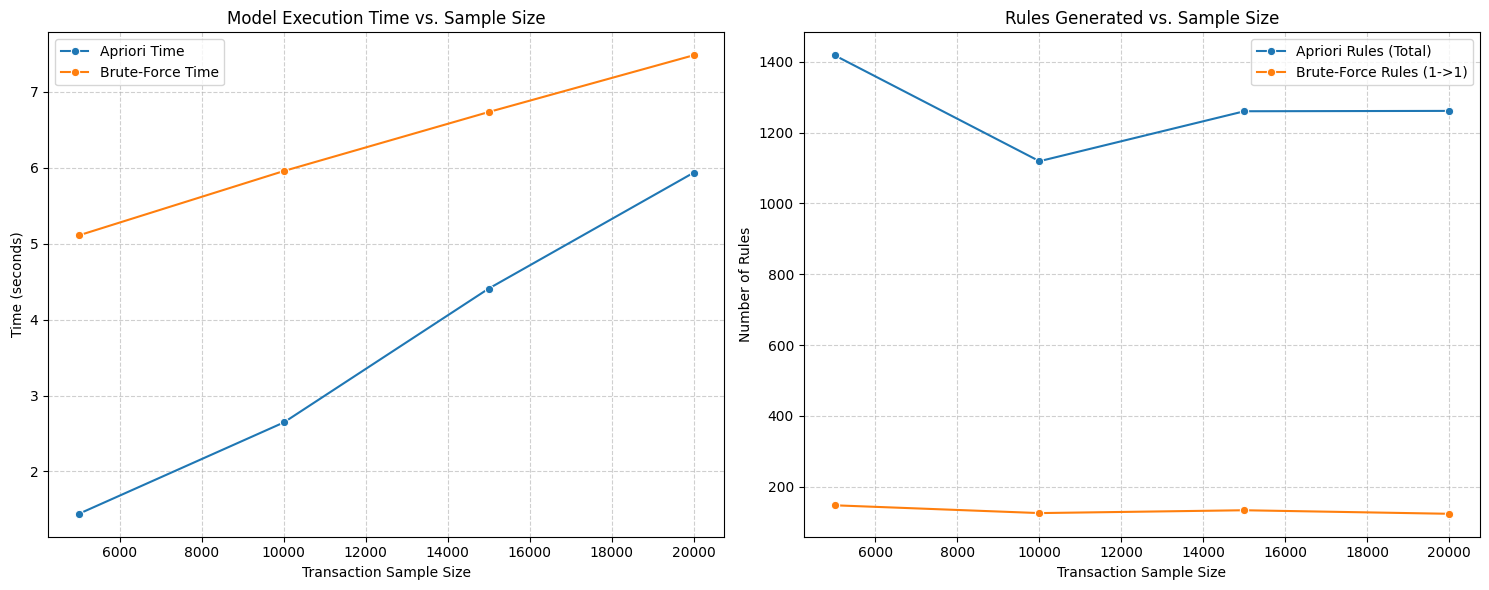

In [ ]:

# --- Configuration ---
RESULTS_DIR = "../results"
ACTIONABLE_LIFT = 1.2
ACTIONABLE_CONFIDENCE = 0.6
RESULTS_PATH = os.path.join(RESULTS_DIR, "comparison_results.csv")
RULES_PATH = os.path.join(RESULTS_DIR, "final_rules_apriori.csv")

# Ensure the results directory exists (important if this is run separately)
os.makedirs(RESULTS_DIR, exist_ok=True)


# Comparison and Scalability Analysis

print("\n" + "="*80)
print("Scalability Comparison: Time and Rule Count")
print("="*80)

if not os.path.exists(RESULTS_PATH):
    print(f"ERROR: Comparison results not found at {RESULTS_PATH}. Please run 02_ohe_and_analyze.py first.")
    exit()

comparison_df = pd.read_csv(RESULTS_PATH)
print("## Performance Comparison Table")
print(comparison_df.set_index('Sample Size').to_string())

# --- Visualization of Scalability ---

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Execution Time
sns.lineplot(data=comparison_df, x='Sample Size', y='Apriori Time', marker='o', label='Apriori Time', ax=axes[0])
sns.lineplot(data=comparison_df, x='Sample Size', y='Brute-Force Time', marker='o', label='Brute-Force Time', ax=axes[0])
axes[0].set_title('Model Execution Time vs. Sample Size')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_xlabel('Transaction Sample Size')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Rules Found
sns.lineplot(data=comparison_df, x='Sample Size', y='Apriori Rules', marker='o', label='Apriori Rules (Total)', ax=axes[1])
sns.lineplot(data=comparison_df, x='Sample Size', y='Brute-Force Rules', marker='o', label='Brute-Force Rules (1->1)', ax=axes[1])
axes[1].set_title('Rules Generated vs. Sample Size')
axes[1].set_ylabel('Number of Rules')
axes[1].set_xlabel('Transaction Sample Size')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

# --- Saving the figure ---
image_path = os.path.join(RESULTS_DIR, "scalability_comparison.png")
plt.savefig(image_path, dpi=300, bbox_inches='tight') 
print(f"Scalability comparison plot saved to: {image_path}")

plt.show() # Display the plot
